# __Car Dataset Analysis and Selling Price Prediction__

## Project Content

<a id = 0></a>

### First Step: First Organization

1. [Introduction](#1)
2. [Loading packages and Defining Functions to Embark Our New Journey](#2)
3. [Loading and Checking The Dataset](#3)

### Second Step: Data Preprocessing

4. [Exploratory Data Analysis](#4)
5. [Adding an Integer Field for Each Categorical Field](#5)
6. [Correlation Analysis](#6)
7. [Dealing with Outliers](#7)
8. [Seperating Data into Two Parts of Train and Development Datasets](#8)

### Third and Final Step: Modeling

9. [Linear Regression](#9)
10. [Extreme Gradient Boosting Regression](#10)
11. [Light Gradient Boosting Machine Regression](#11)
12. [Gradient Boosting Regression](#12)
13. [Cat Boost Regression](#13)
14. [Conclusion](#14)


## 1. Introduction <a id = 1></a>

Here we want to work on a car dataset contains 301 records and 9 features. These features are:

- **Car_Name**

    This field shows the cars' names and has a different variation of car models. It doesn't seem to be helpful in our project.
    But we have to check out its values to be sure if we don't want to use this field in our model.

- **Year**

    The older the vehicle, the chepaer the price! We can assume this hypothesis but what if a car was a kind of antiquate. We don't know and have to check these ideas.

- **Selling_Price**

    In the end it seems that we want to predict the selling price of a car with an eclectic set of features. We will discuss more about this later on the project.

- **Present_Price**

    I don't know but I guess the price of a used vehicle to sell highly depends on its new one's selling price. But wait to check this hypothesis statistically,

- **Kms_Driven**

    humm... The older the car, we can assume it has been used more. What to do now? It seems both the features year and kms driven are telling us the same thing.

- **Fuel_Type**

    I have no idea about how the fuel type change the price of a car. We'll discuss about this issue later.

- **Seller_Type**

    I think dealer can sell a car in a higher price. If not, what's the reason to be a diller? :)

- **Transmission**

    How does the transmission type can determine the selling price? No idea.

- **Owner**

    And the last field is the owner feature and we have no information about this field. I presume this field tells us about how many owners a car has had till now? Am I right?

[Project Content](#0)

## 2. Loading packages and Defining Functions to Embark Our New Journey <a id = 2></a>

In [1]:
# Basic Python Packages

import warnings
warnings.filterwarnings("ignore")

# Numpy Library

import numpy as np

# Pandas Library

import pandas as pd

# Visualization Libraries (Matplotlib, Seaborn, Missingno)

import matplotlib.pyplot as plt
import seaborn as sns
import missingno

# Statsmodels Modules

from statsmodels.stats.outliers_influence import variance_inflation_factor

# SciPy

from scipy.stats import shapiro

# Sklean Modules

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor

# Other Modeling Modules

from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor

%matplotlib inline

In [2]:
def f_num_unique_values(dataframe, fields = None):
    """
    By this function we can check how many unique values each field has

    Args:
        dataframe (pandas.core.frame.DataFrame): The main dataframe
        fields (list): The fields we want to check number of their unique values
    """
    
    num_unique_values_df = pd.DataFrame(columns = ["Field_Name", "Unique_Values_Num"])

    if fields == None:
        fields = dataframe.columns
        
    num_unique_values = []

    for field in fields:
        
        num_unique_values += [dataframe[field].nunique()]
        
    num_unique_values_df["Field_Name"] = fields
    num_unique_values_df["Unique_Values_Num"] = num_unique_values
        
    return num_unique_values_df

In [3]:
def f_unique_values(dataframe, fields):
    """
    By this function we can get a dataframe and categorical fields and show a dataframe of unique values of each field.

    Args:
        dataframe (pandas.core.frame.DataFrame): The main dataframe
        fields (list): The fields we want to check their unique values
        
    Returns:
        unique_values_df (pandas.core.frame.DataFrame): A dataframe of fields and their unique values
    """
    
    unique_values_df = pd.DataFrame(columns = ["Field_Name", "Unique_Values"])

    fields_list = []
    unique_values_list = []

    for field in fields:

        fields_list += [field]
        field_unique_values_list = list(dataframe[field].unique())
            
        unique_values_str = ""
            
        for values_str in field_unique_values_list:
            if field_unique_values_list.index(values_str) != len(field_unique_values_list) - 1:
                unique_values_str += str(values_str) + " | "
            else:
                unique_values_str += str(values_str)                 
            
        unique_values_list += [unique_values_str]
        
    unique_values_df["Field_Name"] = fields_list
    unique_values_df["Unique_Values"] = unique_values_list
        
    return unique_values_df

In [4]:
def f_cat_to_int(dataframe, fields = None):
    """
    This function helps to change categorical fields' values to numerical format.

    Args:
        dataframe (pandas.core.frame.DataFrame): The main dataframe
        fields (list): The fields which we want to duplicate a integer format of them

    Returns:
        dataframe (pandas.core.frame.DataFrame): A dataframe which categorical fields have integer values
    """
    
    if fields == None:
        fields = list(dataframe.columns)
        
    cat_dict = {}

    for field in fields:
        
        cat_dict[field + "_str"] = list(dataframe[field].unique())
        cat_dict[field + "_int"] = [i for i in range(0, len(list(dataframe[field].unique())))]

        dataframe[field + "_int"] = dataframe[field]
        dataframe[field + "_int"].replace(cat_dict[field + "_str"], cat_dict[field + "_int"], inplace = True)
        
    return dataframe

In [5]:
def f_sorted_correlations(dataframe, fields = None, omited_fields = None, target_field = None, cat_num = None):
    """
    This function get a dataframe and fields to create a dataframe of correlation based on our demands.
    It can show a dataframe of correlations between each two fields in a sorted manner and also it can show a one row sorted correlation values between non-target fields and the target.

    Args:
        dataframe (pandas.core.frame.DataFrame): The main dataframe
        fields (list, optional): The fields we want to check their correlation
        omited_fields (list, optional): The fields we dont want to check their correlation
        target_field (list, optional): The target field we want to check its correlation with other fields
        cat_num (list, optional): The target field we want to check its correlation with other fields
        
    Returns:
        corr_df (pandas.core.frame.DataFrame): Final correlation matrix
    """
    
    if fields == None:
        fields = list(dataframe.columns)
    
    corr_dict = {}
    all_correlation_df = dataframe[fields].corr()
    
    if cat_num == None:
        
        if omited_fields != None:
            all_correlation_df.drop(omited_fields, axis = 0, inplace = True)
            all_correlation_df.drop(omited_fields, axis = 1, inplace = True)
        
        if target_field == None:
            for row in range(0, len(list(all_correlation_df.columns))):
                for column in range(row, len(list(all_correlation_df.columns))):
                    if row < column:
                        corr_dict[f"{list(all_correlation_df.columns)[row]}, {list(all_correlation_df.columns)[column]}"] = all_correlation_df.iloc[row, column]

            corr_df = pd.DataFrame(columns = ["Fields", "Correlation_Value"])

            corr_df["Fields"] = list(corr_dict.keys())
            corr_df["Correlation_Value"] = list(corr_dict.values())
            corr_df.sort_values(by = "Correlation_Value", inplace = True)
            
        else:
            corr_df = all_correlation_df[[target_field]]
            corr_df = corr_df.sort_values(by = target_field)
            corr_df.drop(target_field, axis = 0, inplace = True)
            corr_df = corr_df.T
            
    else:
        
        corr_df = ((dataframe[cat_num[0] + cat_num[1]].corr()[cat_num[0]]).T)[cat_num[1]]

    return corr_df

In [6]:
def f_vif_function(dataframe, omited_fields = None):
    """
    This function show a dataframe with sorted values of VIF of each field.

    Args:
        dataframe (pandas.core.frame.DataFrame): The main dataframe
        omited_fields (list, optional): The fields we dont want to check their correlation
                
    Returns:
        vif_info (pandas.core.frame.DataFrame): _description_
    """
    
    if omited_fields != None:
        dataframe.drop(omited_fields, axis = 1, inplace = True)
        
    vif_dict = {}
    
    vif_dict["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    vif_df = ((pd.DataFrame(vif_dict, index = dataframe.columns)).sort_values(by = "VIF").T)
    
    return vif_df

In [7]:
def f_train_dev_split(dataframe, target_field):
    """
    This function gets a dataframe and split it into two train and development dataframes.

    Args:
        dataframe (pandas.core.frame.DataFrame): The main dataframe
        target_field (sring): The field we want to create the linear regression model based on that

    Returns:
        x_train, x_develop, y_train, y_develop (pandas.core.frame.DataFrame): Anything we want for modeling
    """
    
    x = dataframe.drop([target_field], axis = 1)
    y = dataframe[target_field]
    
    x_train, x_develop, y_train, y_develop = train_test_split(x, y, test_size = 0.20, random_state = 3)

    print(f"Train (x) dataset shape is:      {x_train.shape}")
    print(f"Train (y) dataset shape is:      {y_train.shape}")

    print(f"Dev (x) dataset shape is:       {x_develop.shape}")
    print(f"Dev (y) dataset shape is:       {y_develop.shape}")
    
    return x_train, x_develop, y_train, y_develop

In [8]:
def f_linear_regression(train , dev):
    """
    This function has been defined to model a linear regression and show R squared value of train and development datasets.

    Args:
        train (list): A list of both x and y dataframes for training the model
        dev (list): A list of both x and y dataframes for checking the model

    Returns:
        results (pandas.core.frame.DataFrame): R squared value of the model of both train and dev datasets
    """
    
    model = LinearRegression()
    model.fit(train[0], train[1])
    
    results = pd.DataFrame(columns = ["Train", "Dev"], index = ["R Squared"])
    results["Train"] = [model.score(train[0], train[1])]
    results["Dev"] = [model.score(dev[0], dev[1])]
    
    fields = list((train[0]).columns)
    coefficients = list(model.coef_)
    coefficients_dict = {fields[i]: coefficients[i] for i in range(len(fields))}
    sorted_coefficients_dict = sorted(coefficients_dict.items(), key = lambda x : x[1])
    
    intercept = model.intercept_
    
    print(f"Coefficients values:")
    
    for i in range(len(fields)):
        print(f"    * {sorted_coefficients_dict[i][0]} : {round((sorted_coefficients_dict[i][1]), 2)}")
    
    print(f"\nInetrcept: {model.intercept_}\n")
    
    return results

[Project Content](#0)

## 3. Loading and Checking The Dataset <a id = 3></a>

### Loading The Dataset

In [9]:
df = pd.read_csv("Car-Dataset.csv")

### Checking The Dataset

In [10]:
df.head(5)

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


### Examining Missing Values

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


Fortunately there are no null values in fields and we don't mind fixing this issue.

### Examining Number of Unique Values

In [12]:
f_num_unique_values(df)

,Field_Name,Unique_Values_Num
0,Car_Name,98
1,Year,16
2,Selling_Price,156
3,Present_Price,147
4,Kms_Driven,206
5,Fuel_Type,3
6,Seller_Type,2
7,Transmission,2
8,Owner,3


We can consider four last fields (Fuel_Type, Seller_Type, Transmission and Owner) categorical.

Cars' names field won't be helpful cause its values are so diverse, so we can omit that.

In [13]:
del df["Car_Name"]

df.head(5)

,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


### Separating Fields to Numerical and Categorical

In [14]:
fields_list = list(df.columns)
cat_f = ["Fuel_Type", "Seller_Type", "Transmission", "Owner"]
num_f = fields_list

for column in cat_f:
    num_f.remove(column)

print("Categorical fields are:      ", cat_f)
print("Numerical fields are:        ", num_f)

Categorical fields are:       ['Fuel_Type', 'Seller_Type', 'Transmission', 'Owner']
Numerical fields are:         ['Year', 'Selling_Price', 'Present_Price', 'Kms_Driven']


[Project Content](#0)

## 4. Exploratory Data Analysis <a id = 4></a>

### Examining Statistics of Numeric Fields

Here we want to check how fields are distributed. Firstly we can check this table that has a lot of useful information.

In [15]:
df[num_f].describe()

,Year,Selling_Price,Present_Price,Kms_Driven
count,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980
std,2.891554,5.082812,8.644115,38886.883882
min,2003.000000,0.100000,0.320000,500.000000
25%,2012.000000,0.900000,1.200000,15000.000000
50%,2014.000000,3.600000,6.400000,32000.000000
75%,2016.000000,6.000000,9.900000,48767.000000
max,2018.000000,35.000000,92.600000,500000.000000


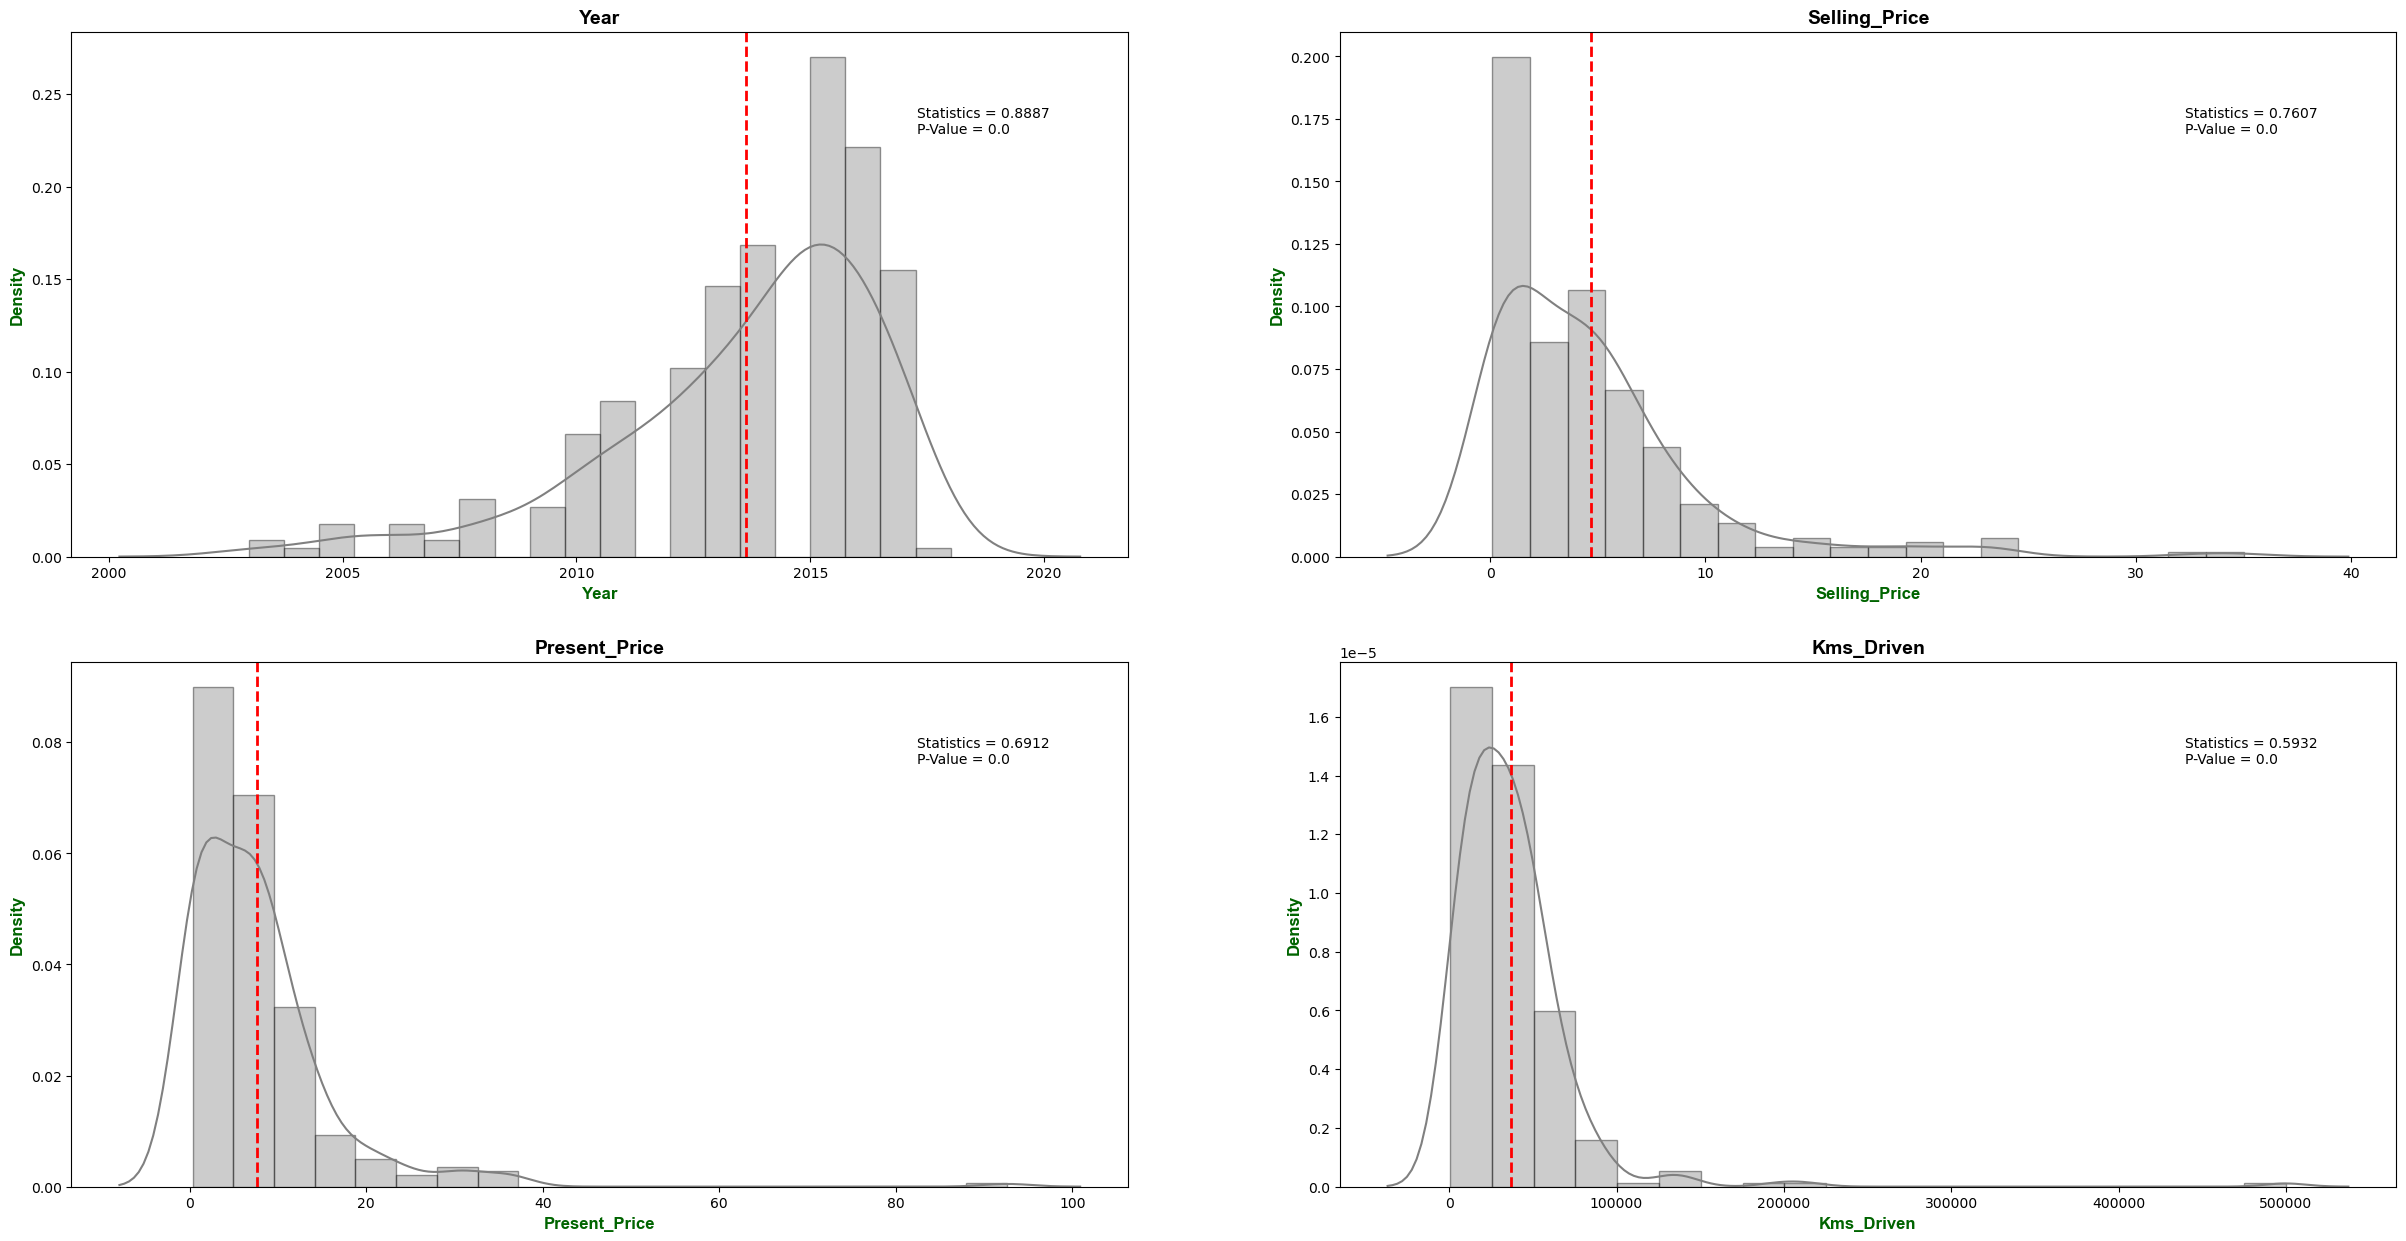

In [16]:
title_font = {"family" : "arial", "color" : "k", "weight" : "bold", "size" : 14}
axes_font = {"family" : "arial", "color" : "darkgreen", "weight" : "bold", "size" : 12}

figure, axis = plt.subplots(2, 2, figsize = (30, 15))

i = 0
j = 0

for field in num_f:
    
    sns.distplot(df[field], kde = True, bins = 20, color = "gray", hist_kws = dict(linewidth = 1, edgecolor = "k"), ax = axis[i, j])
    axis[i, j].axvline(df[field].mean(), color = "r", ls = "--", lw = 2)
                
    axis[i, j].set_title(field, fontdict = title_font)
    axis[i, j].set_xlabel(field, fontdict = axes_font)
    axis[i, j].set_ylabel("Density", fontdict = axes_font)
    axis[i, j].annotate(f"Statistics = {round(shapiro(df[field])[0], 4)}\nP-Value = {round(shapiro(df[field])[1], 4)}",
               xy = (0.8, 0.8), xycoords = "axes fraction", fontsize = 10, horizontalalignment = "left", verticalalignment = "bottom")
    
    if ((j + 1) % 2) != 0:
        j += 1
    
    else:
        j = 0
        i += 1
  
plt.show()

Checking the plots above can be helpful in understanding fields' data approximate distributions. Are they close to normal distributions? Let's check this out!

Using shapiro test can shows us that fields above cannot be considered to have a normal distribution. However we can overlook this issue as we want to use regression model later.

### Examining Statistics of Categorical Fields

In [17]:
f_unique_values(df, cat_f)

,Field_Name,Unique_Values
0,Fuel_Type,Petrol | Diesel | CNG
1,Seller_Type,Dealer | Individual
2,Transmission,Manual | Automatic
3,Owner,0 | 1 | 3


Using the function defined before isn't enough for us. We want to know more about the proportion of each kind of unique values in categorical fields.

Pie plot can be helpful to understand more about values and their proportion in each field.

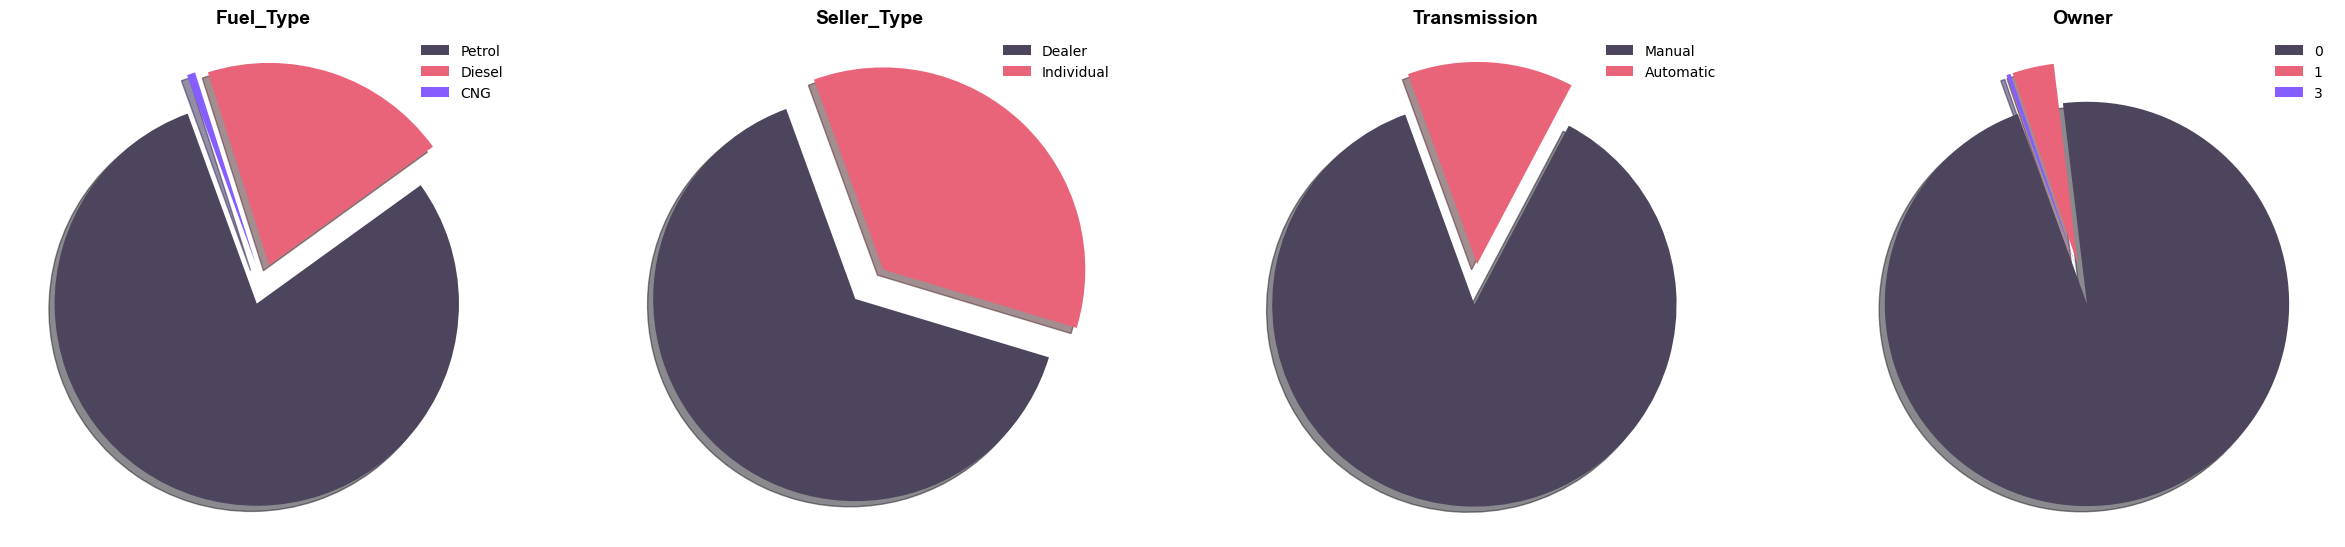

In [18]:
title_font = {"family" : "arial", "color" : "k", "weight" : "bold", "size" : 14}
text_font = {"family" : "arial", "color" : "k", "size" : 10}

colors = ["#4D455D", "#E96479", "#865DFF"]
explode = (0.1,)

figure, axis = plt.subplots(1, 4, figsize = (30, 40))

for field in cat_f:
    
    field_unique_values_list = list(df[field].unique())
    i = cat_f.index(field)
    
    axis[i].pie((np.array(df[field].value_counts())),
                labeldistance = 100, startangle = 110, colors = colors, shadow = True,
                explode = explode * len(np.array(df[field].value_counts())))
    
    axis[i].set_title(field, fontdict = title_font)
    axis[i].legend(field_unique_values_list, loc = "upper right", frameon = False)
  
plt.show()

[Project Content](#0)

## 5. Adding an Integer Field for Each Categorical Field <a id = 5></a> 

In [19]:
df = f_cat_to_int(df, fields = cat_f[:-1])

df

,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Fuel_Type_int,Seller_Type_int,Transmission_int
0,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0,0,0,0
1,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0,1,0,0
2,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0,0,0,0
3,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0,0,0,0
4,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
296,2016,9.50,11.60,33988,Diesel,Dealer,Manual,0,1,0,0
297,2015,4.00,5.90,60000,Petrol,Dealer,Manual,0,0,0,0
298,2009,3.35,11.00,87934,Petrol,Dealer,Manual,0,0,0,0
299,2017,11.50,12.50,9000,Diesel,Dealer,Manual,0,1,0,0


Changing the categorical fields' data type to numerical can help us to find out the relation between fields and create regression models later.

Before correlaytion analysis we want to check if function functions correctly :)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              301 non-null    int64  
 1   Selling_Price     301 non-null    float64
 2   Present_Price     301 non-null    float64
 3   Kms_Driven        301 non-null    int64  
 4   Fuel_Type         301 non-null    object 
 5   Seller_Type       301 non-null    object 
 6   Transmission      301 non-null    object 
 7   Owner             301 non-null    int64  
 8   Fuel_Type_int     301 non-null    int64  
 9   Seller_Type_int   301 non-null    int64  
 10  Transmission_int  301 non-null    int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 26.0+ KB


In [21]:
cat_f_int = [i + "_int" for i in cat_f[:-1]] + [cat_f[-1]]

cat_f_int

['Fuel_Type_int', 'Seller_Type_int', 'Transmission_int', 'Owner']

From now we mostly use integer alternative fields of categorical fields.

[Project Content](#0)

## 6. Correlation Analysis <a id = 6></a> 

### Analysis between Numeric Fields Among Themselves

In [22]:
f_sorted_correlations(df, num_f, omited_fields = "Selling_Price")

,Fields,Correlation_Value
1,"Year, Kms_Driven",-0.524342
0,"Year, Present_Price",-0.047584
2,"Present_Price, Kms_Driven",0.203647


It seems there is multicollinearity between Year and Kms_Driven fields.

### Correlation Analysis between Numeric Fields and Target

In [23]:
f_sorted_correlations(df, num_f, target_field = "Selling_Price")

,Kms_Driven,Year,Present_Price
Selling_Price,0.029187,0.236141,0.878983


Among numerical fields Kms_Driven's correlation coefficiency is not high enough to say that there is a relation between this field and target field.

### Correlation Analysis between Categorical Among Themselves

In [24]:
f_sorted_correlations(df, fields = cat_f_int)

,Fields,Correlation_Value
0,"Fuel_Type_int, Seller_Type_int",-0.352415
3,"Seller_Type_int, Transmission_int",-0.063240
2,"Fuel_Type_int, Owner",-0.055705
5,"Transmission_int, Owner",0.050316
1,"Fuel_Type_int, Transmission_int",0.080466
4,"Seller_Type_int, Owner",0.124269


### Correlation Analysis between Categorical Fields and Target

In [25]:
f_sorted_correlations(df, cat_f_int + ["Selling_Price"], target_field = "Selling_Price")

,Seller_Type_int,Owner,Transmission_int,Fuel_Type_int
Selling_Price,-0.550724,-0.088344,0.367128,0.509467


Among categorical fields Owner's correlation coefficiency is not high enough to say that there is a relation between this field and target field.

### Numeric and Categorical Fields Correlation Analysis

In [26]:
f_sorted_correlations(df, cat_num = [cat_f_int, num_f]).drop(["Selling_Price"], axis = 1)

,Year,Present_Price,Kms_Driven
Fuel_Type_int,0.053643,0.440415,0.166801
Seller_Type_int,-0.039896,-0.512030,-0.101419
Transmission_int,-0.000394,0.348715,0.162510
Owner,-0.182104,0.008057,0.089216


It seems there are multicollinearity between Fuel_Type and Seller_Type and Present_Price fields.

In [27]:
f_vif_function(df[num_f + cat_f_int], omited_fields = ["Selling_Price"])

,Owner,Transmission_int,Fuel_Type_int,Kms_Driven,Seller_Type_int,Present_Price,Year
VIF,1.065787,1.36193,1.620168,2.042232,2.229093,3.164007,4.427574


By checking VIF value of each field we can consider if multicollinearity between fields are high enough to think about a root solution.

### Making Decision About Fields to Keep and Relation Between Fields

In [28]:
correlated_f = ["Year", "Present_Price", "Fuel_Type_int", "Seller_Type_int", "Transmission_int"]

We can consider the list above the most correlated fields for predicting selling price.

[Project Content](#0)

## 7. Dealing with Outliers <a id = 7></a> 

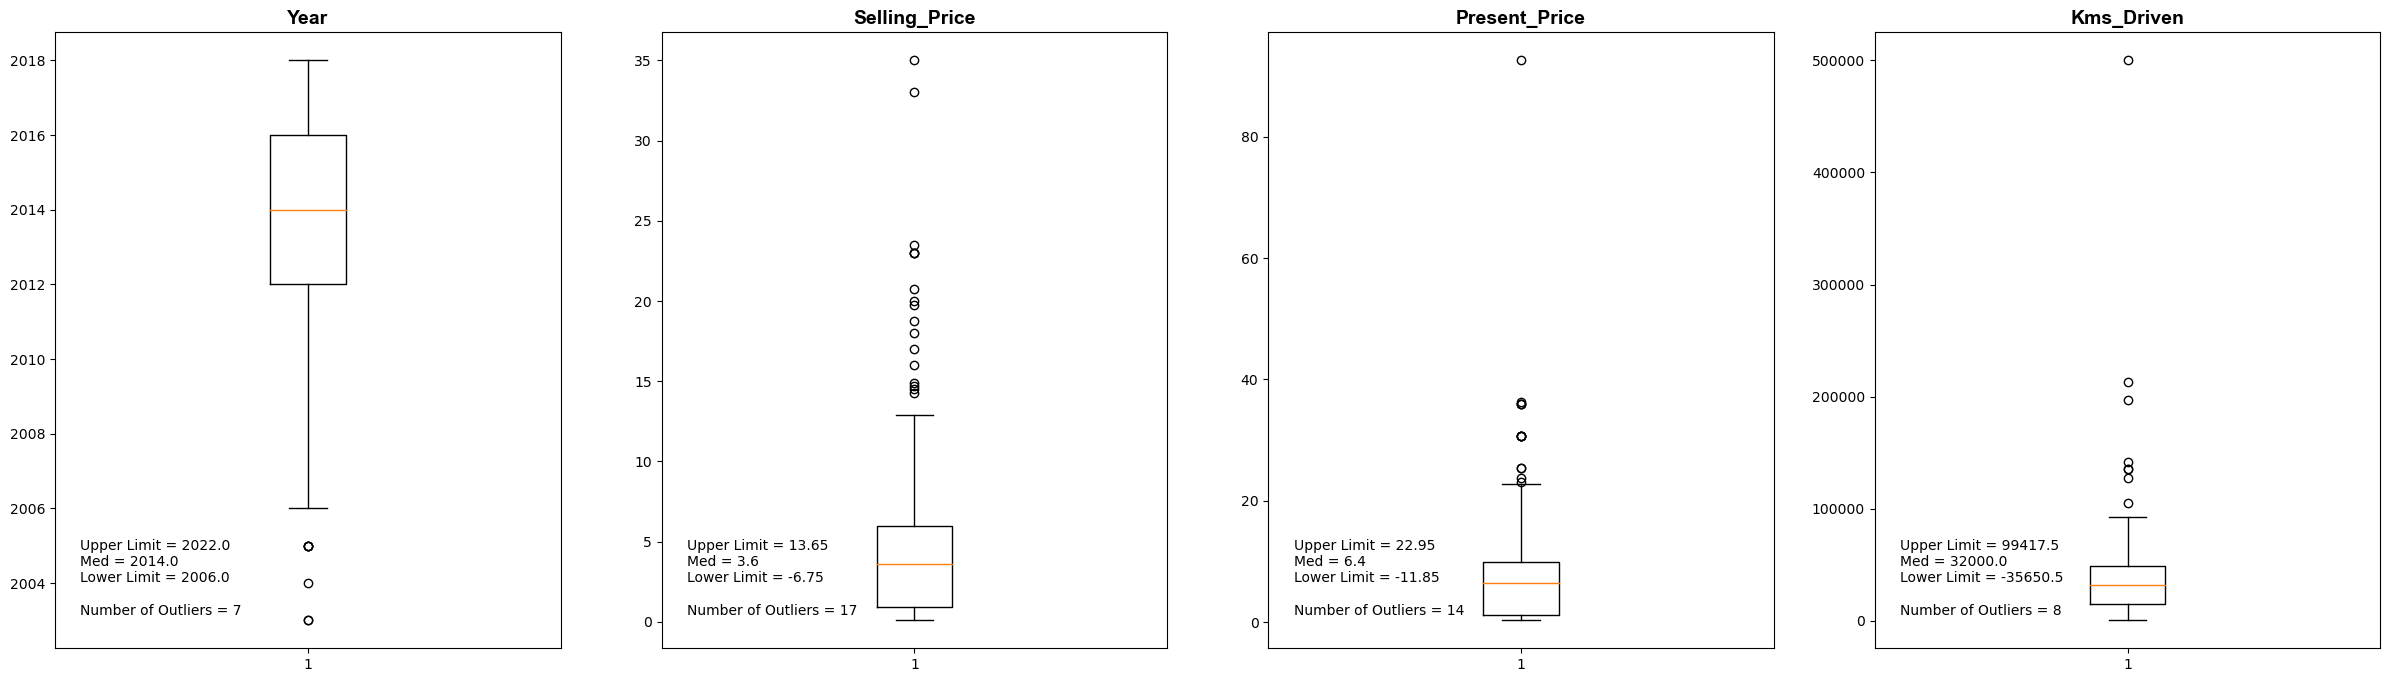

In [29]:
title_font = {"family" : "arial", "color" : "k", "weight" : "bold", "size" : 14}
text_font = {"family" : "arial", "color" : "k", "size" : 10}

figure, axis = plt.subplots(1, 4, figsize = (30, 8))
outliers_index_list = []

for field in num_f:
    
    i = num_f.index(field)
    q1 = df[field].quantile(q = 0.25)
    q3 = df[field].quantile(q = 0.75)
    iqr = q3 - q1
    u = round(q3 + 1.5 * iqr, 2)
    l = round(q1 - 1.5 * iqr, 2)
    
    outliers_df = pd.concat([df[df[field] > u], df[df[field] < l]])
    outliers_index_list += list(outliers_df.index)
    
    axis[i].boxplot(df[field])
    axis[i].set_title(field, fontdict = title_font)
    axis[i].annotate(f"""Upper Limit = {u}\nMed = {df[field].median()}\nLower Limit = {l}\n\nNumber of Outliers = {len(outliers_df)}""",
                     xy = (0.05, 0.05), xycoords = "axes fraction", fontsize = 10, horizontalalignment = "left", verticalalignment = "bottom")
    
plt.show()

As it seems these four fields have some outlier datapoints and for fixing this issue I've prefered to omit the datapoins which are considered outlier simultaneously in all fields.

To check if this approach is the best one, we plot the boxplots again after deleting these datapoints.

In [30]:
outliers_index_list = list(set(outliers_index_list))

print("Number of outliers that have a very high or very low value in all numerical fields:  ", len(outliers_index_list))

no_ol_df = df.drop(index = outliers_index_list)

Number of outliers that have a very high or very low value in all numerical fields:   27


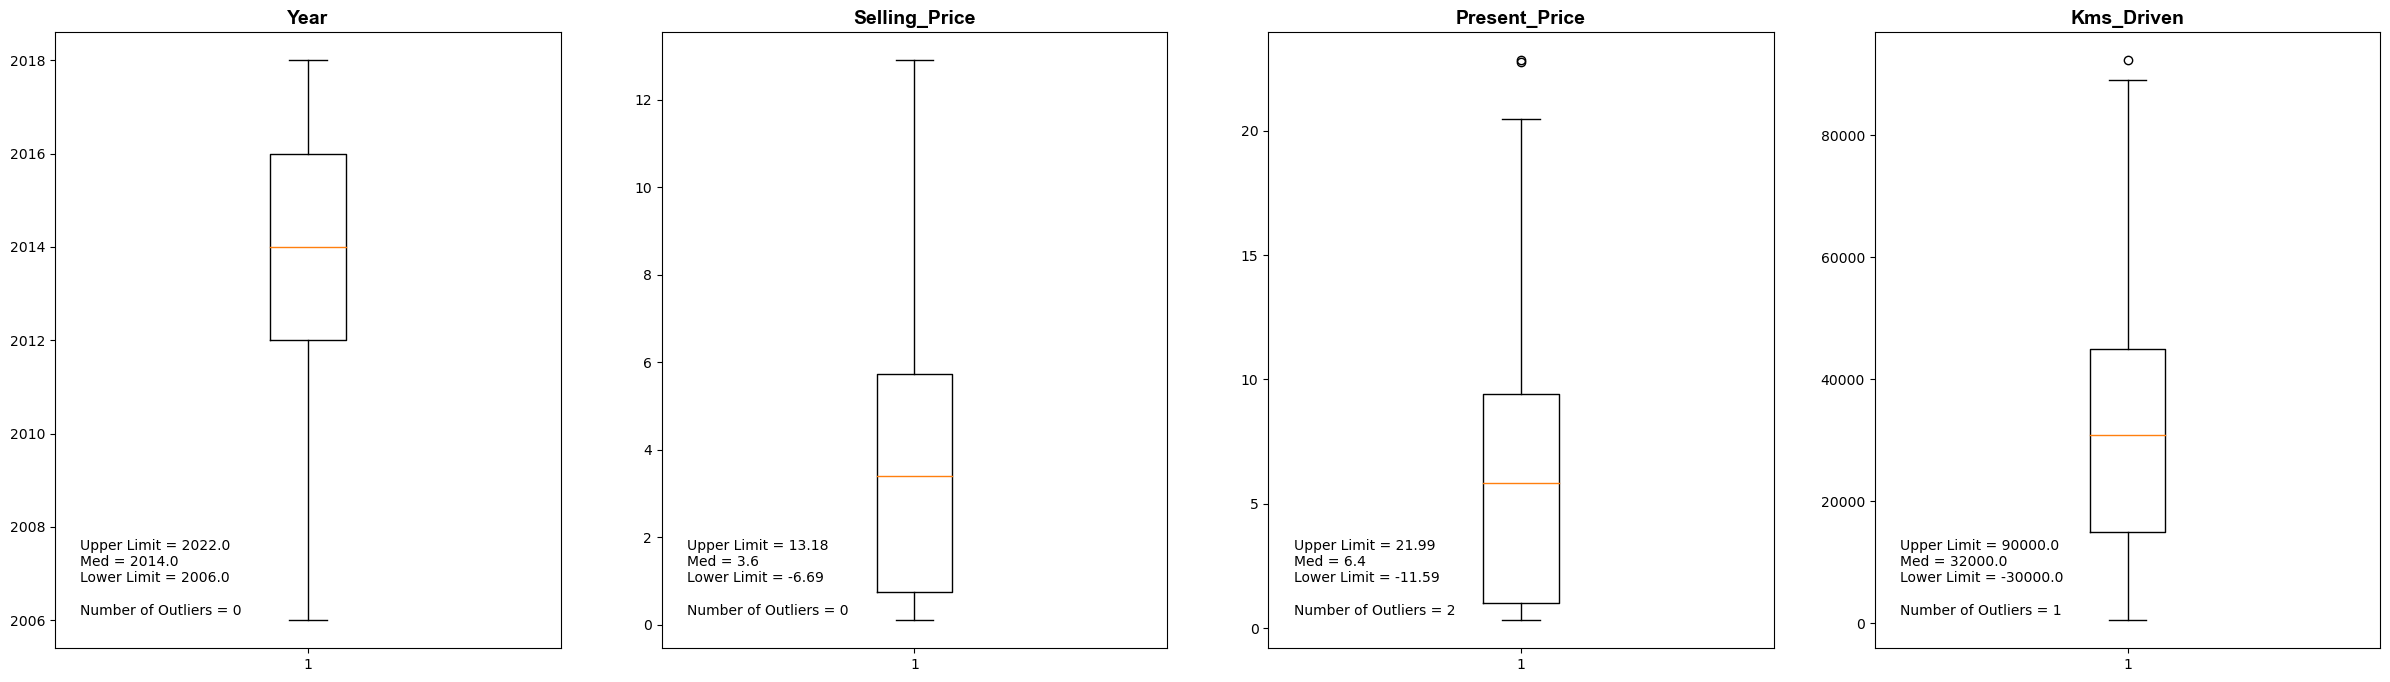

In [31]:
title_font = {"family" : "arial", "color" : "k", "weight" : "bold", "size" : 14}
text_font = {"family" : "arial", "color" : "k", "size" : 10}

figure, axis = plt.subplots(1, 4, figsize = (30, 8))

for field in num_f:
    
    i = num_f.index(field)
    q1 = no_ol_df[field].quantile(q = 0.25)
    q3 = no_ol_df[field].quantile(q = 0.75)
    iqr = q3 - q1
    u = round(q3 + 1.5 * iqr, 2)
    l = round(q1 - 1.5 * iqr, 2)
    
    outliers_df = pd.concat([no_ol_df[no_ol_df[field] > u], no_ol_df[no_ol_df[field] < l]])
    outliers_index_list += list(outliers_df.index)
    
    axis[i].boxplot(no_ol_df[field])
    axis[i].set_title(field, fontdict = title_font)
    axis[i].annotate(f"""Upper Limit = {u}\nMed = {df[field].median()}\nLower Limit = {l}\n\nNumber of Outliers = {len(outliers_df)}""",
                     xy = (0.05, 0.05), xycoords = "axes fraction", fontsize = 10, horizontalalignment = "left", verticalalignment = "bottom")
    
plt.show()

It seems OK. Nice :)

[Project Content](#0)

## 8. Seperating Data into Two Parts of Train and Development Datasets <a id = 8></a> 

Now we are in the latest parts in our journey. Before anyhing else let's our dataframe again...

In [33]:
no_ol_df

,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Fuel_Type_int,Seller_Type_int,Transmission_int
0,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0,0,0,0
1,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0,1,0,0
2,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0,0,0,0
3,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0,0,0,0
4,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
296,2016,9.50,11.60,33988,Diesel,Dealer,Manual,0,1,0,0
297,2015,4.00,5.90,60000,Petrol,Dealer,Manual,0,0,0,0
298,2009,3.35,11.00,87934,Petrol,Dealer,Manual,0,0,0,0
299,2017,11.50,12.50,9000,Diesel,Dealer,Manual,0,1,0,0


Checking the fields we want to use in our model...

In [34]:
print(f"Numerical Fields:     {num_f}")
print(f"Categorical Fields:   {cat_f_int}\n")

print(f"Numeric Fields Correlated to Target:   {[i for i in correlated_f if i in num_f]}")
print(f"Numeric Fields Correlated to Target:   {[i for i in correlated_f if i in cat_f_int]}")

Numerical Fields:     ['Year', 'Selling_Price', 'Present_Price', 'Kms_Driven']
Categorical Fields:   ['Fuel_Type_int', 'Seller_Type_int', 'Transmission_int', 'Owner']

Numeric Fields Correlated to Target:   ['Year', 'Present_Price']
Numeric Fields Correlated to Target:   ['Fuel_Type_int', 'Seller_Type_int', 'Transmission_int']


Check Check Check. Let's split the dataset into two parts (train and development).

In [36]:
x_t_corr, x_d_corr, y_t_corr, y_d_corr = f_train_dev_split(no_ol_df[correlated_f + ["Selling_Price"]], "Selling_Price")

Train (x) dataset shape is:      (219, 5)
Train (y) dataset shape is:      (219,)
Dev (x) dataset shape is:       (55, 5)
Dev (y) dataset shape is:       (55,)


I'm not sure if it's the best approuch to use correlated fields. It won't hurt if we check our model performance using all fields.

In [35]:
x_t, x_d, y_t, y_d = f_train_dev_split(no_ol_df[num_f + cat_f_int], "Selling_Price")

Train (x) dataset shape is:      (219, 7)
Train (y) dataset shape is:      (219,)
Dev (x) dataset shape is:       (55, 7)
Dev (y) dataset shape is:       (55,)


Nearly finished. For this part of the project, checking some regression models and determining the most accurate model are the last steps.

[Project Content](#0)

## 9. Linear Regression  <a id = 9></a> 

In [37]:
f_linear_regression([x_t, y_t], [x_d, y_d])

Coefficients values:
    * Seller_Type_int : -1.46
    * Kms_Driven : -0.0
    * Transmission_int : 0.14
    * Owner : 0.23
    * Year : 0.3
    * Present_Price : 0.44
    * Fuel_Type_int : 0.99

Inetrcept: -598.314221554429



,Train,Dev
R Squared,0.865454,0.808194


In [38]:
f_linear_regression([x_t_corr, y_t_corr], [x_d_corr, y_d_corr])

Coefficients values:
    * Seller_Type_int : -1.36
    * Transmission_int : 0.2
    * Year : 0.37
    * Present_Price : 0.42
    * Fuel_Type_int : 0.83

Inetrcept: -748.7243285368875



,Train,Dev
R Squared,0.859181,0.788377


[Project Content](#0)

## 10. Extreme Gradient Boost Regression  <a id = 10></a> 

In [39]:
model = XGBRegressor()
model.fit(x_t, y_t)

feature_importance_dict = {}

for feature in list(model.feature_names_in_):
    feature_importance_dict[feature] = round(list(model.feature_importances_)[list(model.feature_names_in_).index(feature)], 3)
    
print("Train dataset accuracy is:       ", model.score(x_t, y_t))
print("Development dataset accuracy is: ", model.score(x_d, y_d), "\n")

print("The most important features are:" , feature_importance_dict)

Train dataset accuracy is:        0.9999976728228114
Development dataset accuracy is:  0.8983801010321644 

The most important features are: {'Year': 0.082, 'Present_Price': 0.785, 'Kms_Driven': 0.022, 'Fuel_Type_int': 0.079, 'Seller_Type_int': 0.0, 'Transmission_int': 0.029, 'Owner': 0.003}


In [40]:
model = XGBRegressor()
model.fit(x_t_corr, y_t_corr)

feature_importance_dict = {}

for feature in list(model.feature_names_in_):
    feature_importance_dict[feature] = round(list(model.feature_importances_)[list(model.feature_names_in_).index(feature)], 3)
    
print("Train dataset accuracy is:       ", model.score(x_t_corr, y_t_corr))
print("Development dataset accuracy is: ", model.score(x_d_corr, y_d_corr), "\n")

print("The most important features are:" , feature_importance_dict)

Train dataset accuracy is:        0.9969684747083013
Development dataset accuracy is:  0.9132161033126132 

The most important features are: {'Year': 0.13, 'Present_Price': 0.805, 'Fuel_Type_int': 0.054, 'Seller_Type_int': 0.001, 'Transmission_int': 0.01}


[Project Content](#0)

## 11. Light Gradient Boosting Machine Regression  <a id = 11></a> 

In [41]:
model = LGBMRegressor()
model.fit(x_t, y_t)

feature_importance_dict = {}

for feature in list(model.feature_name_):
    feature_importance_dict[feature] = list(model.feature_importances_)[list(model.feature_name_).index(feature)]

print("Train dataset accuracy is:       ", model.score(x_t, y_t))
print("Development dataset accuracy is: ", model.score(x_d, y_d), "\n")

print("The most important features are:" , feature_importance_dict)

Train dataset accuracy is:        0.9734609302883472
Development dataset accuracy is:  0.915261296735642 

The most important features are: {'Year': 143, 'Present_Price': 328, 'Kms_Driven': 180, 'Fuel_Type_int': 68, 'Seller_Type_int': 15, 'Transmission_int': 4, 'Owner': 0}


In [42]:
model = LGBMRegressor()
model.fit(x_t_corr, y_t_corr)

feature_importance_dict = {}

for feature in list(model.feature_name_):
    feature_importance_dict[feature] = list(model.feature_importances_)[list(model.feature_name_).index(feature)]

print("Train dataset accuracy is:       ", model.score(x_t_corr, y_t_corr))
print("Development dataset accuracy is: ", model.score(x_d_corr, y_d_corr), "\n")

print("The most important features are:" , feature_importance_dict)

Train dataset accuracy is:        0.9612426408913688
Development dataset accuracy is:  0.9264514415449389 

The most important features are: {'Year': 197, 'Present_Price': 432, 'Fuel_Type_int': 61, 'Seller_Type_int': 14, 'Transmission_int': 5}


[Project Content](#0)

## 12. Gradient Boosting Regression  <a id = 12></a> 

In [43]:
model = GradientBoostingRegressor()
model.fit(x_t, y_t)

feature_importance_dict = {}

for feature in list(model.feature_names_in_):
    feature_importance_dict[feature] = round(list(model.feature_importances_)[list(model.feature_names_in_).index(feature)], 3)

print("Train dataset accuracy is:       ", model.score(x_t, y_t))
print("Development dataset accuracy is: ", model.score(x_d, y_d), "\n")

print("The most important features are:" , feature_importance_dict)

Train dataset accuracy is:        0.9937404383649722
Development dataset accuracy is:  0.9313754647630874 

The most important features are: {'Year': 0.093, 'Present_Price': 0.87, 'Kms_Driven': 0.025, 'Fuel_Type_int': 0.01, 'Seller_Type_int': 0.0, 'Transmission_int': 0.001, 'Owner': 0.0}


In [44]:
model = GradientBoostingRegressor()
model.fit(x_t_corr, y_t_corr)

feature_importance_dict = {}

for feature in list(model.feature_names_in_):
    feature_importance_dict[feature] = round(list(model.feature_importances_)[list(model.feature_names_in_).index(feature)], 3)

print("Train dataset accuracy is:       ", model.score(x_t_corr, y_t_corr))
print("Development dataset accuracy is: ", model.score(x_d_corr, y_d_corr), "\n")

print("The most important features are:" , feature_importance_dict)

Train dataset accuracy is:        0.9895115419712122
Development dataset accuracy is:  0.9457960192805741 

The most important features are: {'Year': 0.106, 'Present_Price': 0.881, 'Fuel_Type_int': 0.011, 'Seller_Type_int': 0.0, 'Transmission_int': 0.002}


[Project Content](#0)

## 13. Cat Boost Regression  <a id = 13></a> 

In [45]:
model = CatBoostRegressor()
model.fit(x_t, y_t)

feature_importance_dict = {}

for feature in list(model.feature_names_):
    feature_importance_dict[feature] = round(list(model.feature_importances_)[list(model.feature_names_).index(feature)], 3)

print("Train dataset accuracy is:       ", model.score(x_t, y_t))
print("Development dataset accuracy is: ", model.score(x_d, y_d), "\n")

print("The most important features are:" , feature_importance_dict)

Learning rate set to 0.032208
0:	learn: 3.0243148	total: 58.4ms	remaining: 58.4s
1:	learn: 2.9601677	total: 59.1ms	remaining: 29.5s
2:	learn: 2.8883647	total: 59.6ms	remaining: 19.8s
3:	learn: 2.8212477	total: 60ms	remaining: 15s
4:	learn: 2.7557492	total: 60.5ms	remaining: 12s
5:	learn: 2.6980939	total: 60.9ms	remaining: 10.1s
6:	learn: 2.6327469	total: 61.4ms	remaining: 8.71s
7:	learn: 2.5766888	total: 61.8ms	remaining: 7.66s
8:	learn: 2.5208159	total: 62.1ms	remaining: 6.84s
9:	learn: 2.4669952	total: 62.5ms	remaining: 6.19s
10:	learn: 2.4154502	total: 62.9ms	remaining: 5.66s
11:	learn: 2.3663895	total: 63.4ms	remaining: 5.22s
12:	learn: 2.3154044	total: 63.8ms	remaining: 4.84s
13:	learn: 2.2701319	total: 64.2ms	remaining: 4.52s
14:	learn: 2.2202181	total: 64.8ms	remaining: 4.26s
15:	learn: 2.1736413	total: 65.4ms	remaining: 4.02s
16:	learn: 2.1289826	total: 65.8ms	remaining: 3.81s
17:	learn: 2.0879393	total: 66.3ms	remaining: 3.62s
18:	learn: 2.0439522	total: 66.7ms	remaining: 3.44

In [46]:
model = CatBoostRegressor()
model.fit(x_t_corr, y_t_corr)

feature_importance_dict = {}

for feature in list(model.feature_names_):
    feature_importance_dict[feature] = round(list(model.feature_importances_)[list(model.feature_names_).index(feature)], 3)

print("Train dataset accuracy is:       ", model.score(x_t_corr, y_t_corr))
print("Development dataset accuracy is: ", model.score(x_d_corr, y_d_corr), "\n")

print("The most important features are:" , feature_importance_dict)

Learning rate set to 0.032208
0:	learn: 3.0247939	total: 1.08ms	remaining: 1.08s
1:	learn: 2.9516985	total: 1.32ms	remaining: 659ms
2:	learn: 2.8843077	total: 1.4ms	remaining: 465ms
3:	learn: 2.8138095	total: 1.6ms	remaining: 397ms
4:	learn: 2.7540602	total: 1.81ms	remaining: 360ms
5:	learn: 2.6930818	total: 2.07ms	remaining: 343ms
6:	learn: 2.6351922	total: 2.27ms	remaining: 323ms
7:	learn: 2.5780246	total: 2.46ms	remaining: 305ms
8:	learn: 2.5219538	total: 2.66ms	remaining: 293ms
9:	learn: 2.4656646	total: 2.98ms	remaining: 296ms
10:	learn: 2.4141580	total: 3.17ms	remaining: 285ms
11:	learn: 2.3682997	total: 3.46ms	remaining: 285ms
12:	learn: 2.3193481	total: 3.68ms	remaining: 279ms
13:	learn: 2.2675358	total: 4.03ms	remaining: 284ms
14:	learn: 2.2190318	total: 4.32ms	remaining: 284ms
15:	learn: 2.1708976	total: 4.57ms	remaining: 281ms
16:	learn: 2.1219451	total: 4.75ms	remaining: 275ms
17:	learn: 2.0769857	total: 5ms	remaining: 273ms
18:	learn: 2.0319723	total: 5.2ms	remaining: 268m

[Project Content](#0)

## 14. Conclusion <a id = 14></a> 

Awesome :)) We've done the best we could and it seems satisfactory.

As a result the best model is CatBoostRegrssor as it has the most R-Squared value in development dataset (95.26 %).

Also all regression models show better results when they get just correlated fields as input.

[Project Content](#0)